# Modeling Hot Water Energy

### Select the parameters for the experiment and log in the experiment folder

In [1]:
# %%writefile param_sets.json
seed_value = 123  # seed for the experiment
Trial = 2  # number of the experiment

period = 6  # the period to sample the data at. 1 period= 5 minutes

inputcols = ['oat', 'orh', 'sat-oat', 'ghi', 'hw_sf', 'hx_vlv1',]  # input predictors
x_loc = [4,5]  # vars we want to plot in detailed plot
outputcols = ['hwe']  # output targets
input_timesteps = 1  # number of timesteps for the input sequence
output_timesteps = 1  # number of timesteps for the output sequence

# Smoothing
smooth_data = True  # whetter to smooth the data or not
order = 5  # order of the filer
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

# adjust out of phase data
adjust_lag = True  # whether to adjust the lag for certain columns
lag_columns = outputcols  # choose columns to adjust lag
data_lag = -1  # lag by how many periods: negative means shift column upwards

# aggregate data based on period
aggregate_data = True  # aggregate data or not
rolling_sum_target = ['hwe', 'hw_sf']  # create sum aggregate for these columns
rolling_mean_target = [
    'hw_st', 'hw_rt', 'oat', 'sat-oat', 'sat', 'orh', 'ghi', 'avg_stpt','hx_vlv1'
]  # create mean aggregate for these columns

# create temporal batches of data: df2dflist
days, hours = 7, 0

#threshold: lower bound below which we ignore the row data(needed for removing hybrid system)
threshold = 2

# Custom way to create Training Data
data_weeks = 52  # Create a large initial block 6 months ~ 26 weeks of training and testing data
create_lag = 0  # Create further lags in the output
scaling = True  # Scale the input and output features
feature_range = (0, 1)  # Scaling range
reshaping = True  # reshape data according to (batch_size, time_steps, features)

# model configuration
modelconfig = {
    'lstm_hidden_units': 16,
    'lstm_no_layers': 1,
    'dense_hidden_units': 16,
    'dense_no_layers': 4,
    'retrain_from_layers': 0,
    'stateful': False,
    'train_batchsize':32,
    'test_batchsize':1, # we are doing online prediction
    'train_epochs': 5000,
}

# wheter doing adaptive for fixed learning
adaptive_control = True  # whether we relearn or keep it fixed
path = '../results/' + outputcols[0] + '_model{}/'.format(
    Trial) + 'adaptive/' * adaptive_control + 'fixed/' * (1 - adaptive_control)
#!rm -rf ../results/lstm_hwe_trial8/adaptive

#model design considerations
modeldesigndone = False  # whether model will be reinitialized
initial_epoch = 0  # the start epoch number for the training

# These are automatically superseded and ignored if adaptive_control is set to False
retain_prev_model = True  # retain weights of model from previous training
freeze_model = False  # freeze weights of certain layers
reinitialize = False  # reinitialize the weights of certain layers
model_saved = False  # whether model has been saved once
test_model_created = False  # create an idectical model for online predicton

# data used for learning the model
datapath = '../data/processed/buildingdata.pkl'

# additional info
addl = {
    'metainfo': 'create a diff of sat and oat for hot water energy prediction as it is useful. See 1.0.8',
    'names_abreviation': {
        'oat':'Outside Air Temperature',
        'orh':'Outside Air Relative Humidity',
        'sat-oat' : 'Difference of Supply Air and Outside Air Temps ',
        'ghi': 'Global Solar Irradiance',
        'hw_sf':'Hot Water System Flow Rate',
        'hx_vlv1':'Hot Water Valve %',
        'hw_st':'Hot Water Supply Temperature'
    }
}
x_lab = [addl['names_abreviation'][inputcols[i]] for i in x_loc]

### Set Seed in numpy, Keras and TF for reproducability
### Import modules
### Set GPU configurations

In [2]:
import shutil
import glob
import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
from tqdm import tqdm
import parse
import warnings
from matplotlib.dates import date2num

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [5]:
# %load_ext tensorboard
# %tensorboard --logdir '../results/lstm_hwe_trial1/loginfo/' --port 8200

### Create Folder to save models and tensorboard logs

In [4]:
# create the results directory
try:
    os.makedirs(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        try:
            shutil.rmtree(path + f)
        except NotADirectoryError:
            os.remove(path + f)
        
os.mkdir(path + 'loginfo')
os.mkdir(path + 'normalplots')
os.mkdir(path + 'detailedplots')

### Save the experiment parameters and configurations

In [5]:
#save the values
paramsdict = {
    
    'seed_value' : seed_value,
    
    'period':period,
    
    'inputcols':inputcols,
    'x_loc': x_loc,
    'outputcols':outputcols,
    'input_timesteps':input_timesteps,
    'output_timesteps':output_timesteps,
    
    'smooth_data': smooth_data,
    'order' : 5,
    'T' : T,
    'fs' : fs,
    'cutoff' : cutoff,
    
    'adjust_lag' : adjust_lag,
    'lag_columns' : lag_columns,
    'data_lag' : data_lag,
    
    'aggregate_data' : aggregate_data,
    'rolling_sum_target' : rolling_sum_target,
    'rolling_mean_target' : rolling_mean_target,
    
    'days':days,
    'hours':hours,
    
    'threshold': threshold,
    
    'data_weeks' : data_weeks,
    'create_lag' : create_lag,
    'scaling' : scaling,
    'feature_range' : feature_range,
    'reshaping' : reshaping,
    
    'modelconfig' : modelconfig,
    
    'adaptive_control':adaptive_control,
    'path':path,
    
    'modeldesigndone' : modeldesigndone,
    'initial_epoch' : initial_epoch,
    
    'retain_prev_model' : retain_prev_model,
    'freeze_model' : freeze_model,
    'reinitialize' : reinitialize,
    'model_saved' : model_saved,
    'test_model_created': test_model_created,
    
    'datapath' : datapath,
    
    'addl' : addl,
}
    
# with open(path+'params.json', 'r') as fp:
#     param2dict = json.load(fp)

with open(path+'params.json', 'w') as fp:
    json.dump(paramsdict, fp, indent=4)

### Read the cleaned data

In [6]:
# read the pickled file for ahu data
dfdata = dp.readfile(datapath)

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

### Create additional Data columns as needed

In [7]:
df['sat-oat']= df['sat']-df['oat']

# show data
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,hx_vlv1,sat-oat
2018-07-13 07:50:00,80.913567,79.320808,82.0,0.0,32.546185,562.0,69.52381,39.534317,0.0,94.427994,89.589584,0.276543,-1.592758
2018-07-13 07:55:00,80.913567,79.023285,82.0,0.0,29.293947,580.0,69.52381,39.809956,0.0,94.125771,89.589584,0.276543,-1.890282
2018-07-13 08:00:00,80.615402,79.023285,82.0,0.0,30.685425,597.0,69.52381,39.174774,0.0,94.125771,89.589584,0.276543,-1.592117
2018-07-13 08:05:00,80.303123,79.023285,82.0,0.0,30.074446,614.0,69.52381,35.745533,0.0,93.816162,89.229790,0.276543,-1.279839
2018-07-13 08:10:00,80.303123,79.023285,79.0,0.0,29.646845,625.0,69.52381,34.858036,0.0,93.816162,89.229790,0.276543,-1.279839


### Smooth the data

In [8]:
if smooth_data:
    df = dp.dfsmoothing(df=df,
                        column_names=list(df.columns),
                        order=order,
                        Wn=cutoff,
                        T=T)

### Adjust lag for certain columns if needed

In [9]:
if adjust_lag:
    df = dp.createlag(df, lag_columns, lag=data_lag)

### Create aggregate data: aggregate specified columns at specified intervals

In [10]:
# return a new column which is the sum of previous window_size values
def window_sum(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).sum()

# return a new column which is the average of previous window_size values
def window_mean(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).mean()

# rolling_sum_output = ['{}min_{}_sum'.format(5*period,target) for target in rolling_sum_target]
# rolling_mean_output = ['{}min_{}_mean'.format(5*period,target) for target in rolling_mean_target]

if aggregate_data:
    
    # rolling sum
    df[rolling_sum_target] =  window_sum(df, window_size=period, column_names=rolling_sum_target)
    
    # rolling mean
    df[rolling_mean_target] =  window_mean(df, window_size=period, column_names=rolling_mean_target)
    
    df = dp.dropNaNrows(df)
    
    # Sample the data at period intervals
    df = dp.sample_timeseries_df(df, period=period)

### Create temporal chunks of data

In [11]:
df = df[(df['hw_sf']>=1) &
          (df['hx_vlv1']>=1) &
         (df['hwe']>=1)]

In [12]:
df.describe()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,hx_vlv1,sat-oat
count,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000
mean,60.727431,71.289459,63.555467,28.610134,22.235469,199.444702,71.619015,37.379938,70.923475,103.116424,93.005845,33.112716,10.562028
std,17.435641,4.632896,16.479486,25.263229,17.132262,267.921329,1.030264,31.076252,53.575259,15.366989,14.126037,16.525377,18.391333
min,17.821972,52.080394,19.934095,1.000257,-1.817882,-45.539274,66.053821,-1.813372,1.016329,85.850610,64.979626,1.004894,-22.825744
25%,45.299535,69.477079,51.292765,10.170216,5.631252,0.116391,70.933273,7.805205,30.030583,90.232045,82.873901,18.242504,-4.515705
50%,64.234703,72.200607,63.485525,17.899037,21.083460,49.041770,71.409524,33.488808,56.262033,93.863386,86.428545,32.953288,4.111303
75%,75.269014,73.953667,77.417426,44.666493,37.642339,354.747279,72.647618,64.238311,88.171776,116.225728,101.392132,47.940542,28.614864
max,94.560829,90.031056,95.007589,160.411511,66.524093,960.175891,73.558137,123.605894,195.213976,147.491708,135.359499,73.435671,55.312001


In [13]:
# Creating a list of "days" day dataframes for training
dflist = dp.df2dflist_alt(df[inputcols+outputcols],
                      subsequence=True,
                      period=period,
                      days=days,
                      hours=hours)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 75


### Custom way to create Training Data

In [14]:
# Since we are training across time, we need to ensure the input and output time steps are now 1
# otherwise the rearrangment of the data for batch speedup will be violated
assert (input_timesteps == 1) & (
    output_timesteps == 1), "Input and Output timesteps must be 1 for this notebook"

#### Create placeholder and functions

In [15]:
from pandas import concat, Timedelta


def quickmerge(listdf):
    return concat(listdf)


def df_list_reshape(datablock_df):
    new_df_list = []
    for i in range(int(10080 / (5 * period))):
        new_df_list.append(
            datablock_df[(datablock_df.index - datablock_df.index[i]) %
                         Timedelta('7 days') == '0 days 00:00:00'])
    return new_df_list

weeklist = []  # create list of training, testing arrays

#### Initial Data Block for offline training: select n weeks of data and extract continuous batches of size a least greater than LSTM training batch size and train on thise batches

In [16]:
# select and merge data_weeks-1 worth of data
datablock_train_pre = dflist[0:data_weeks-1]
datablock_train = quickmerge(datablock_train_pre)
#divide into non-zero operating region
datablock_train = dp.subsequencing(datablock_train, period=period)
#drop smaller blocks
datablock_train = [item for item in datablock_train if item.shape[0] >= 0.05*modelconfig['train_batchsize']]
#merge them together
minibatch_train = quickmerge(datablock_train)

# select weeks=1 worth of data
datablock_test_pre = dflist[data_weeks-1]
#divide into non-zero operating region
datablock_test = dp.subsequencing(datablock_test_pre, period=period)
#drop smaller blocks
datablock_test = [item for item in datablock_test if item.shape[0] >= 0.05*modelconfig['test_batchsize']]
#merge them together
minibatch_test = quickmerge(datablock_test)


# splitvalue
splitvalue = minibatch_test.shape[0]
#merge test and train together
data_block = quickmerge([minibatch_train, minibatch_test])

# create numpy arrays
X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

# select test ids for later plots
test_idx = minibatch_test.index

# append them
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(minibatch_test.index[int(splitvalue/2)].year), 
                                      str(minibatch_test.index[int(splitvalue/2)].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })


#### Create small blocks of data for weekly training

In [17]:
for weekdata in dflist[data_weeks:]:
    
    # select and merge data_weeks-1 worth of data
    datablock_train_pre = datablock_train_pre[1:]+[datablock_test_pre]
    datablock_train = quickmerge(datablock_train_pre)
    #divide into non-zero operating region
    datablock_train = dp.subsequencing(datablock_train, period=period)
    #drop smaller blocks
    datablock_train = [item for item in datablock_train if item.shape[0] >= 0.05*modelconfig['train_batchsize']]
    #merge them together
    minibatch_train = quickmerge(datablock_train)
    
    # select weeks=1 worth of data
    datablock_test_pre = weekdata
    #divide into non-zero operating region
    datablock_test = dp.subsequencing(datablock_test_pre, period=period)
    #drop smaller blocks
    datablock_test = [item for item in datablock_test if item.shape[0] >= 0.05*modelconfig['test_batchsize']]
    #merge them together
    minibatch_test = quickmerge(datablock_test)
    
    # splitvalue
    splitvalue = minibatch_test.shape[0]
    #merge test and train together
    data_block = quickmerge([minibatch_train, minibatch_test])

    # and add new week data from weekdata
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

    # select test ids for later plots
    test_idx = minibatch_test.index

    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(minibatch_test.index[int(splitvalue/2)].year), 
                                      str(minibatch_test.index[int(splitvalue/2)].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })
    
print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 24


#### Print size and shape of data to feed to the LSTM for sanity checks

In [18]:
for week in weeklist:
    for key,value in week.items():
        if (key != 'y_scaler') & (key != 'X_scaler') :
            print("name: {}, shape: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, shape: Year-2019-Week-30
name: X_train, shape: (10786, 1, 6)
name: y_train, shape: (10786, 1, 1)
name: X_test, shape: (271, 1, 6)
name: y_test, shape: (271, 1, 1)
name: test_idx, shape: (271,)
name: Id, shape: Year-2019-Week-31
name: X_train, shape: (10867, 1, 6)
name: y_train, shape: (10867, 1, 1)
name: X_test, shape: (209, 1, 6)
name: y_test, shape: (209, 1, 1)
name: test_idx, shape: (209,)
name: Id, shape: Year-2019-Week-32
name: X_train, shape: (10885, 1, 6)
name: y_train, shape: (10885, 1, 1)
name: X_test, shape: (131, 1, 6)
name: y_test, shape: (131, 1, 1)
name: test_idx, shape: (131,)
name: Id, shape: Year-2019-Week-33
name: X_train, shape: (10904, 1, 6)
name: y_train, shape: (10904, 1, 1)
name: X_test, shape: (46, 1, 6)
name: y_test, shape: (46, 1, 1)
name: test_idx, shape: (46,)
name: Id, shape: Year-2019-Week-34
name: X_train, shape: (10870, 1, 6)
name: y_train, shape: (10870, 1, 1)
name: X_test, shape: (188, 1, 6)
name: y_test, shape: (188, 1, 1)
name: test_idx, sh

#### Add weekly train test data to modelconfig dictionary for ease of training

In [19]:
modelconfig['weeklist'] = weeklist

###  Clear the Tensorflow graph from previous training

In [20]:
try:
    del nn_model
except NameError:
    pass

K.clear_session()

### Inspect model architecture

In [ ]:
# weekdata = modelconfig['weeklist'][0]
# X_train = weekdata['X_train']
# y_train = weekdata['y_train']
# X_test = weekdata['X_test']
# y_test = weekdata['y_test']
# y_scaler = weekdata['y_scaler']

# #Instantiate learner model
# nn_model = mp.seq2seq_model(path,
#                       inputdim=X_train.shape[-1],
#                       outputdim=y_train.shape[-1],
#                       period=period)

# # Desing model architecture
# nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
#                    densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                    dropoutlist=[[], []],
#                    batchnormalizelist=[[], []])

# # compile model
# nn_model.model_compile()

# nn_model.model.summary()

### Perform relearning on chunks of temporal data

In [21]:
for weekno, BatchData in enumerate(tqdm(modelconfig['weeklist'])):

    """Begin weekly training"""   
    X_train = BatchData['X_train']
    y_train = BatchData['y_train']

    try:
        del nn_model
    except NameError:
        pass

    K.clear_session()

    #Instantiate learner model
    nn_model = mp.simple_LSTM_model(path,
                                  inputdim=X_train.shape[-1],
                                  outputdim=y_train.shape[-1],
                                  input_timesteps=input_timesteps,
                                  output_timesteps = output_timesteps,
                                  period=period,
                                  stateful = modelconfig['stateful'],
                                  batch_size=modelconfig['train_batchsize'])

    # Desing model architecture
    nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])

    # load the trained model weights if we want to: here some layer weights may be reinitialized; see below
    if model_saved & retain_prev_model:
        nn_model.model.load_weights('IntermediateModel.h5')


    # compile model
    nn_model.model_compile()   

    # train the model for adaptive model and fixed after first round for fixed control
    if adaptive_control | (weekno==0):
        history = nn_model.train_model(X_train,
                                       y_train,
                                       epochs=modelconfig['train_epochs'],
                                       initial_epoch=initial_epoch)
        try:
            initial_epoch += len(history.history['loss'])
        except KeyError:
            pass

        # save the model only if trained at least once- needed for prediction model
        nn_model.model.save('IntermediateModel.h5')
        model_saved = True     
    """End Weekly Training"""
    
    
    """Begin Last Week Prediction"""
    
    y_scaler = BatchData['y_scaler']
    X_scaler = BatchData['X_scaler']
    X_test = BatchData['X_test']
    y_test = BatchData['y_test']
   
    try:
        del nn_model_pred
    except NameError:
        pass
    K.clear_session()

    # Separate predictor for predicting online: only difference is test batch size
    nn_model_pred = mp.simple_LSTM_model(path,
                                       inputdim=X_test.shape[-1],
                                       outputdim=y_test.shape[-1],
                                       input_timesteps=input_timesteps,
                                       output_timesteps = output_timesteps,
                                       period=period,
                                       stateful = modelconfig['stateful'],
                                       batch_size=modelconfig['test_batchsize'])

    # Desing model architecture
    nn_model_pred.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])


    # load the trained model weights
    nn_model_pred.model.load_weights('IntermediateModel.h5')
    # compile model
    nn_model_pred.model_compile()

    # evaluate the model for metrics at this stage
    # train and test plots as well as logged errors inside the text file
    preds_test = nn_model_pred.evaluate_model( X_test,
                                               y_test,
                                               y_scaler,
                                               save_plot_loc=path+'normalplots/',
                                               scaling=True,
                                               saveplot=True,
                                               Idx=BatchData['Id'],
                                               outputdim_names=outputcols)

    # do a detailed plot instead
    pu.detailedplot(period * 5,
                    xs = date2num(list(BatchData['test_idx'])),
                    outputdim=len(outputcols),
                    output_timesteps=output_timesteps,
                    input_timesteps=input_timesteps,
                    pred=preds_test,
                    target=y_test,
                    X_var=X_test,
                    x_loc=x_loc,
                    x_lab=x_lab,
                    saveloc=path + 'detailedplots/',
                    scaling=True,
                    Xscaler=X_scaler,
                    yscaler=y_scaler,
                    typeofplot='test',
                    Idx=BatchData['Id'])
    """End Last Week Prediction"""

    """Only execute when we are freezing LSTM and just training on Dense"""
    if adaptive_control:
        
        # freeze all but dense layers at the top and compile with new weights
        if freeze_model:
            for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
                layer.trainable = False

        # for relearning, reinitialize top few layers
        if reinitialize:
            for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
                layer.kernel.initializer.run(session=K.get_session())
                layer.bias.initializer.run(session=K.get_session())

        # recompile model
        if freeze_model | reinitialize:
            nn_model.model_compile()
            
            # save the model- needed for Keras limitations: Tensorboard crashes if we relearn on original model with
            # reinitialized weights; solution: we create new model and load these weights
            nn_model.model.save('IntermediateModel.h5')
            model_saved = True
            
            freeze_model = False
            reinitialize = False

  0%|          | 0/24 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5000
 - 2s - loss: 0.0088
Epoch 2/5000
 - 2s - loss: 0.0047
Epoch 3/5000
 - 2s - loss: 0.0039
Epoch 4/5000
 - 2s - loss: 0.0036
Epoch 5/5000
 - 2s - loss: 0.0034
Epoch 6/5000
 - 2s - loss: 0.0032
Epoch 7/5000
 - 2s - loss: 0.0031
Epoch 8/5000
 - 2s - loss: 0.0029
Epoch 9/5000
 - 2s - loss: 0.0028
Epoch 10/5000
 - 2s - loss: 0.0026
Epoch 11/5000
 - 2s - loss: 0.0024
Epoch 12/5000
 - 2s - loss: 0.0023
Epoch 13/5000
 - 2s - loss: 0.0022
Epoch 14/5000
 - 2s - loss: 0.0022
Epoch 15/5000
 - 2s - loss: 0.0021
Epoch 16/5000
 - 2s - loss: 0.0020
Epoch 17/5000
 - 2s - loss: 0.0020
Epoch 18/5000
 - 2s - loss: 0.0020
Epoch 19/5000
 - 2s - loss: 0.0019
Epoch 20/5000
 - 2s - loss: 0.0016
Epoch 21/5000
 - 2s - loss: 0.0015
Epoch 22/5000
 - 2s - loss: 0.0015
Epoch 23/5000
 - 2s - loss: 0.0015
Epoch 24/5000
 - 2s - loss: 0.0015
Epoch 25/5000
 - 2s - loss: 0.0015
Epoch 26/5000
 - 2s - loss: 0.0015


  4%|▍         | 1/24 [01:24<32:32, 84.90s/it]

Epoch 49/5000
 - 2s - loss: 0.0021
Epoch 50/5000
 - 2s - loss: 0.0018
Epoch 51/5000
 - 2s - loss: 0.0018
Epoch 52/5000
 - 2s - loss: 0.0018
Epoch 53/5000
 - 2s - loss: 0.0017
Epoch 54/5000
 - 2s - loss: 0.0014
Epoch 55/5000
 - 2s - loss: 0.0013
Epoch 56/5000
 - 2s - loss: 0.0013
Epoch 57/5000
 - 2s - loss: 0.0013
Epoch 58/5000
 - 2s - loss: 0.0013
Epoch 59/5000
 - 2s - loss: 0.0013
Epoch 60/5000
 - 2s - loss: 0.0013
Epoch 61/5000
 - 2s - loss: 0.0013
Epoch 62/5000
 - 2s - loss: 0.0013
Epoch 63/5000
 - 2s - loss: 0.0013
Epoch 64/5000
 - 2s - loss: 0.0013
Epoch 65/5000
 - 2s - loss: 0.0013
Epoch 66/5000
 - 2s - loss: 0.0013
Epoch 67/5000
 - 2s - loss: 0.0013
Epoch 68/5000
 - 2s - loss: 0.0013
Epoch 69/5000
 - 2s - loss: 0.0013
Epoch 70/5000
 - 2s - loss: 0.0013
Epoch 71/5000
 - 2s - loss: 0.0013
Epoch 72/5000
 - 2s - loss: 0.0013
Epoch 73/5000
 - 2s - loss: 0.0013
Epoch 74/5000
 - 2s - loss: 0.0013
Epoch 75/5000
 - 2s - loss: 0.0013
Epoch 76/5000
 - 2s - loss: 0.0013
Epoch 77/5000
 - 2s 

  8%|▊         | 2/24 [02:31<29:08, 79.50s/it]

Epoch 87/5000
 - 2s - loss: 0.0019
Epoch 88/5000
 - 2s - loss: 0.0017
Epoch 89/5000
 - 2s - loss: 0.0016
Epoch 90/5000
 - 2s - loss: 0.0016
Epoch 91/5000
 - 2s - loss: 0.0015
Epoch 92/5000
 - 2s - loss: 0.0012
Epoch 93/5000
 - 2s - loss: 0.0012
Epoch 94/5000
 - 2s - loss: 0.0012
Epoch 95/5000
 - 2s - loss: 0.0012
Epoch 96/5000
 - 2s - loss: 0.0011
Epoch 97/5000
 - 2s - loss: 0.0011
Epoch 98/5000
 - 2s - loss: 0.0011
Epoch 99/5000
 - 2s - loss: 0.0011
Epoch 100/5000
 - 2s - loss: 0.0011
Epoch 101/5000
 - 2s - loss: 0.0011
Epoch 102/5000
 - 2s - loss: 0.0011
Epoch 103/5000
 - 2s - loss: 0.0011
Epoch 104/5000
 - 2s - loss: 0.0011
Epoch 105/5000
 - 2s - loss: 0.0011
Epoch 106/5000
 - 2s - loss: 0.0011
Epoch 107/5000
 - 2s - loss: 0.0011
Epoch 108/5000
 - 2s - loss: 0.0011
Epoch 109/5000
 - 2s - loss: 0.0011
Epoch 110/5000
 - 2s - loss: 0.0011
Epoch 111/5000
 - 2s - loss: 0.0011
Epoch 112/5000
 - 2s - loss: 0.0011
Epoch 113/5000
 - 2s - loss: 0.0011
Epoch 114/5000
 - 2s - loss: 0.0011
Epoch

 12%|█▎        | 3/24 [03:30<25:39, 73.31s/it]

Epoch 120/5000
 - 2s - loss: 0.0016
Epoch 121/5000
 - 2s - loss: 0.0015
Epoch 122/5000
 - 2s - loss: 0.0014
Epoch 123/5000
 - 2s - loss: 0.0014
Epoch 124/5000
 - 2s - loss: 0.0014
Epoch 125/5000
 - 2s - loss: 0.0013
Epoch 126/5000
 - 2s - loss: 0.0013
Epoch 127/5000
 - 2s - loss: 0.0010
Epoch 128/5000
 - 2s - loss: 9.8759e-04
Epoch 129/5000
 - 2s - loss: 9.7577e-04
Epoch 130/5000
 - 2s - loss: 0.0011
Epoch 131/5000
 - 2s - loss: 9.2484e-04
Epoch 132/5000
 - 2s - loss: 9.1720e-04
Epoch 133/5000
 - 2s - loss: 9.1496e-04
Epoch 134/5000
 - 2s - loss: 9.1099e-04
Epoch 135/5000
 - 2s - loss: 9.0977e-04
Epoch 136/5000
 - 2s - loss: 9.0891e-04
Epoch 137/5000
 - 2s - loss: 9.0830e-04
Epoch 138/5000
 - 2s - loss: 9.0735e-04
Epoch 139/5000
 - 2s - loss: 9.0730e-04
Epoch 140/5000
 - 2s - loss: 9.0725e-04
Epoch 141/5000
 - 2s - loss: 9.0720e-04
Epoch 142/5000
 - 2s - loss: 9.0710e-04
Epoch 143/5000
 - 2s - loss: 9.0710e-04
Epoch 144/5000
 - 2s - loss: 9.0710e-04
Epoch 145/5000
 - 2s - loss: 9.0709e

 17%|█▋        | 4/24 [04:39<24:02, 72.10s/it]

Epoch 159/5000
 - 2s - loss: 0.0014
Epoch 160/5000
 - 2s - loss: 0.0012
Epoch 161/5000
 - 2s - loss: 0.0013
Epoch 162/5000
 - 2s - loss: 0.0013
Epoch 163/5000
 - 2s - loss: 0.0013
Epoch 164/5000
 - 2s - loss: 9.4659e-04
Epoch 165/5000
 - 2s - loss: 9.2314e-04
Epoch 166/5000
 - 2s - loss: 9.1382e-04
Epoch 167/5000
 - 2s - loss: 0.0010
Epoch 168/5000
 - 2s - loss: 8.6488e-04
Epoch 169/5000
 - 2s - loss: 8.5715e-04
Epoch 170/5000
 - 2s - loss: 8.5511e-04
Epoch 171/5000
 - 2s - loss: 8.5277e-04
Epoch 172/5000
 - 2s - loss: 8.5072e-04
Epoch 173/5000
 - 2s - loss: 8.4940e-04
Epoch 174/5000
 - 2s - loss: 8.4856e-04
Epoch 175/5000
 - 2s - loss: 8.4748e-04
Epoch 176/5000
 - 2s - loss: 8.4741e-04
Epoch 177/5000
 - 2s - loss: 8.4735e-04
Epoch 178/5000
 - 2s - loss: 8.4729e-04
Epoch 179/5000
 - 2s - loss: 8.4718e-04
Epoch 180/5000
 - 2s - loss: 8.4717e-04
Epoch 181/5000
 - 2s - loss: 8.4717e-04
Epoch 182/5000
 - 2s - loss: 8.4717e-04
Epoch 183/5000
 - 2s - loss: 8.4716e-04
Epoch 184/5000
 - 2s - l

 21%|██        | 5/24 [05:44<22:09, 69.97s/it]

Epoch 196/5000
 - 2s - loss: 0.0012
Epoch 197/5000
 - 2s - loss: 0.0012
Epoch 198/5000
 - 2s - loss: 0.0012
Epoch 199/5000
 - 2s - loss: 0.0014
Epoch 200/5000
 - 2s - loss: 9.3273e-04
Epoch 201/5000
 - 2s - loss: 9.0460e-04
Epoch 202/5000
 - 2s - loss: 8.9240e-04
Epoch 203/5000
 - 2s - loss: 0.0010
Epoch 204/5000
 - 2s - loss: 8.4219e-04
Epoch 205/5000
 - 2s - loss: 8.3573e-04
Epoch 206/5000
 - 2s - loss: 8.3381e-04
Epoch 207/5000
 - 2s - loss: 8.3133e-04
Epoch 208/5000
 - 2s - loss: 8.2931e-04
Epoch 209/5000
 - 2s - loss: 8.2807e-04
Epoch 210/5000
 - 2s - loss: 8.2730e-04
Epoch 211/5000
 - 2s - loss: 8.2629e-04
Epoch 212/5000
 - 2s - loss: 8.2623e-04
Epoch 213/5000
 - 2s - loss: 8.2617e-04
Epoch 214/5000
 - 2s - loss: 8.2612e-04
Epoch 215/5000
 - 2s - loss: 8.2601e-04
Epoch 216/5000
 - 2s - loss: 8.2601e-04
Epoch 217/5000
 - 2s - loss: 8.2601e-04
Epoch 218/5000
 - 2s - loss: 8.2600e-04
Epoch 219/5000
 - 2s - loss: 8.2600e-04
Epoch 220/5000
 - 2s - loss: 8.2600e-04
Epoch 221/5000
 - 2s

 25%|██▌       | 6/24 [06:43<20:00, 66.68s/it]

Epoch 229/5000
 - 2s - loss: 0.0014
Epoch 230/5000
 - 2s - loss: 0.0011
Epoch 231/5000
 - 2s - loss: 0.0012
Epoch 232/5000
 - 2s - loss: 0.0012
Epoch 233/5000
 - 2s - loss: 0.0013
Epoch 234/5000
 - 2s - loss: 9.1248e-04
Epoch 235/5000
 - 2s - loss: 8.8746e-04
Epoch 236/5000
 - 2s - loss: 8.7920e-04
Epoch 237/5000
 - 2s - loss: 9.9550e-04
Epoch 238/5000
 - 2s - loss: 8.3622e-04
Epoch 239/5000
 - 2s - loss: 8.2967e-04
Epoch 240/5000
 - 2s - loss: 8.2740e-04
Epoch 241/5000
 - 2s - loss: 8.2463e-04
Epoch 242/5000
 - 2s - loss: 8.2284e-04
Epoch 243/5000
 - 2s - loss: 8.2175e-04
Epoch 244/5000
 - 2s - loss: 8.2108e-04
Epoch 245/5000
 - 2s - loss: 8.2015e-04
Epoch 246/5000
 - 2s - loss: 8.2010e-04
Epoch 247/5000
 - 2s - loss: 8.2006e-04
Epoch 248/5000
 - 2s - loss: 8.2001e-04
Epoch 249/5000
 - 2s - loss: 8.1991e-04
Epoch 250/5000
 - 2s - loss: 8.1991e-04
Epoch 251/5000
 - 2s - loss: 8.1991e-04
Epoch 252/5000
 - 2s - loss: 8.1991e-04
Epoch 253/5000
 - 2s - loss: 8.1990e-04
Epoch 254/5000
 - 2s

 29%|██▉       | 7/24 [07:49<18:49, 66.43s/it]

Epoch 266/5000
 - 2s - loss: 0.0014
Epoch 267/5000
 - 2s - loss: 0.0011
Epoch 268/5000
 - 2s - loss: 0.0011
Epoch 269/5000
 - 2s - loss: 0.0012
Epoch 270/5000
 - 2s - loss: 0.0012
Epoch 271/5000
 - 2s - loss: 9.4426e-04
Epoch 272/5000
 - 2s - loss: 9.0780e-04
Epoch 273/5000
 - 2s - loss: 8.9054e-04
Epoch 274/5000
 - 2s - loss: 9.9539e-04
Epoch 275/5000
 - 2s - loss: 8.4253e-04
Epoch 276/5000
 - 2s - loss: 8.3514e-04
Epoch 277/5000
 - 2s - loss: 8.3248e-04
Epoch 278/5000
 - 2s - loss: 8.2974e-04
Epoch 279/5000
 - 2s - loss: 8.2798e-04
Epoch 280/5000
 - 2s - loss: 8.2685e-04
Epoch 281/5000
 - 2s - loss: 8.2610e-04
Epoch 282/5000
 - 2s - loss: 8.2515e-04
Epoch 283/5000
 - 2s - loss: 8.2509e-04
Epoch 284/5000
 - 2s - loss: 8.2504e-04
Epoch 285/5000
 - 2s - loss: 8.2498e-04
Epoch 286/5000
 - 2s - loss: 8.2488e-04
Epoch 287/5000
 - 2s - loss: 8.2488e-04
Epoch 288/5000
 - 2s - loss: 8.2488e-04
Epoch 289/5000
 - 2s - loss: 8.2487e-04
Epoch 290/5000
 - 2s - loss: 8.2487e-04
Epoch 291/5000
 - 2s

 33%|███▎      | 8/24 [09:00<18:05, 67.83s/it]

Epoch 306/5000
 - 2s - loss: 0.0016
Epoch 307/5000
 - 2s - loss: 0.0012
Epoch 308/5000
 - 2s - loss: 0.0010
Epoch 309/5000
 - 2s - loss: 0.0011
Epoch 310/5000
 - 2s - loss: 0.0011
Epoch 311/5000
 - 2s - loss: 0.0014
Epoch 312/5000
 - 2s - loss: 9.1124e-04
Epoch 313/5000
 - 2s - loss: 8.8000e-04
Epoch 314/5000
 - 2s - loss: 8.6654e-04
Epoch 315/5000
 - 2s - loss: 9.4790e-04
Epoch 316/5000
 - 2s - loss: 8.2535e-04
Epoch 317/5000
 - 2s - loss: 8.1997e-04
Epoch 318/5000
 - 2s - loss: 8.1798e-04
Epoch 319/5000
 - 2s - loss: 8.1511e-04
Epoch 320/5000
 - 2s - loss: 8.1368e-04
Epoch 321/5000
 - 2s - loss: 8.1278e-04
Epoch 322/5000
 - 2s - loss: 8.1220e-04
Epoch 323/5000
 - 2s - loss: 8.1140e-04
Epoch 324/5000
 - 2s - loss: 8.1136e-04
Epoch 325/5000
 - 2s - loss: 8.1132e-04
Epoch 326/5000
 - 2s - loss: 8.1127e-04
Epoch 327/5000
 - 2s - loss: 8.1119e-04
Epoch 328/5000
 - 2s - loss: 8.1119e-04
Epoch 329/5000
 - 2s - loss: 8.1119e-04
Epoch 330/5000
 - 2s - loss: 8.1118e-04
Epoch 331/5000
 - 2s - l

 38%|███▊      | 9/24 [10:09<17:00, 68.00s/it]

Epoch 345/5000
 - 2s - loss: 0.0011
Epoch 346/5000
 - 2s - loss: 0.0011
Epoch 347/5000
 - 2s - loss: 0.0014
Epoch 348/5000
 - 2s - loss: 0.0011
Epoch 349/5000
 - 2s - loss: 9.1063e-04
Epoch 350/5000
 - 2s - loss: 8.8161e-04
Epoch 351/5000
 - 2s - loss: 8.6746e-04
Epoch 352/5000
 - 2s - loss: 9.3862e-04
Epoch 353/5000
 - 2s - loss: 8.2734e-04
Epoch 354/5000
 - 2s - loss: 8.2176e-04
Epoch 355/5000
 - 2s - loss: 8.1965e-04
Epoch 356/5000
 - 2s - loss: 8.1600e-04
Epoch 357/5000
 - 2s - loss: 8.1500e-04
Epoch 358/5000
 - 2s - loss: 8.1433e-04
Epoch 359/5000
 - 2s - loss: 8.1388e-04
Epoch 360/5000
 - 2s - loss: 8.1315e-04
Epoch 361/5000
 - 2s - loss: 8.1312e-04
Epoch 362/5000
 - 2s - loss: 8.1308e-04
Epoch 363/5000
 - 2s - loss: 8.1305e-04
Epoch 364/5000
 - 2s - loss: 8.1297e-04
Epoch 365/5000
 - 2s - loss: 8.1297e-04
Epoch 366/5000
 - 2s - loss: 8.1297e-04
Epoch 367/5000
 - 2s - loss: 8.1297e-04
Epoch 368/5000
 - 2s - loss: 8.1296e-04
Epoch 369/5000
 - 2s - loss: 8.1296e-04
Epoch 370/5000
 

 42%|████▏     | 10/24 [11:09<15:17, 65.52s/it]

Epoch 379/5000
 - 2s - loss: 0.0010
Epoch 380/5000
 - 2s - loss: 0.0011
Epoch 381/5000
 - 2s - loss: 0.0012
Epoch 382/5000
 - 2s - loss: 0.0013
Epoch 383/5000
 - 2s - loss: 9.0302e-04
Epoch 384/5000
 - 2s - loss: 8.7112e-04
Epoch 385/5000
 - 2s - loss: 8.5477e-04
Epoch 386/5000
 - 2s - loss: 9.3222e-04
Epoch 387/5000
 - 2s - loss: 8.1395e-04
Epoch 388/5000
 - 2s - loss: 8.0793e-04
Epoch 389/5000
 - 2s - loss: 8.0585e-04
Epoch 390/5000
 - 2s - loss: 8.0317e-04
Epoch 391/5000
 - 2s - loss: 8.0181e-04
Epoch 392/5000
 - 2s - loss: 8.0092e-04
Epoch 393/5000
 - 2s - loss: 8.0032e-04
Epoch 394/5000
 - 2s - loss: 7.9952e-04
Epoch 395/5000
 - 2s - loss: 7.9947e-04
Epoch 396/5000
 - 2s - loss: 7.9943e-04
Epoch 397/5000
 - 2s - loss: 7.9939e-04
Epoch 398/5000
 - 2s - loss: 7.9930e-04
Epoch 399/5000
 - 2s - loss: 7.9930e-04
Epoch 400/5000
 - 2s - loss: 7.9930e-04
Epoch 401/5000
 - 2s - loss: 7.9930e-04
Epoch 402/5000
 - 2s - loss: 7.9929e-04
Epoch 403/5000
 - 2s - loss: 7.9929e-04
Epoch 404/5000
 

 46%|████▌     | 11/24 [12:10<13:56, 64.37s/it]

Epoch 414/5000
 - 2s - loss: 0.0010
Epoch 415/5000
 - 2s - loss: 0.0011
Epoch 416/5000
 - 2s - loss: 0.0011
Epoch 417/5000
 - 2s - loss: 0.0013
Epoch 418/5000
 - 2s - loss: 8.7163e-04
Epoch 419/5000
 - 2s - loss: 8.4097e-04
Epoch 420/5000
 - 2s - loss: 8.2875e-04
Epoch 421/5000
 - 2s - loss: 8.9172e-04
Epoch 422/5000
 - 2s - loss: 7.9075e-04
Epoch 423/5000
 - 2s - loss: 7.8622e-04
Epoch 424/5000
 - 2s - loss: 7.8465e-04
Epoch 425/5000
 - 2s - loss: 7.8202e-04
Epoch 426/5000
 - 2s - loss: 7.8079e-04
Epoch 427/5000
 - 2s - loss: 7.8000e-04
Epoch 428/5000
 - 2s - loss: 7.7949e-04
Epoch 429/5000
 - 2s - loss: 7.7875e-04
Epoch 430/5000
 - 2s - loss: 7.7871e-04
Epoch 431/5000
 - 2s - loss: 7.7867e-04
Epoch 432/5000
 - 2s - loss: 7.7863e-04
Epoch 433/5000
 - 2s - loss: 7.7856e-04
Epoch 434/5000
 - 2s - loss: 7.7855e-04
Epoch 435/5000
 - 2s - loss: 7.7855e-04
Epoch 436/5000
 - 2s - loss: 7.7855e-04
Epoch 437/5000
 - 2s - loss: 7.7855e-04
Epoch 438/5000
 - 2s - loss: 7.7855e-04
Epoch 439/5000
 

 50%|█████     | 12/24 [13:19<13:07, 65.65s/it]

Epoch 453/5000
 - 2s - loss: 9.5801e-04
Epoch 454/5000
 - 2s - loss: 0.0011
Epoch 455/5000
 - 2s - loss: 0.0010
Epoch 456/5000
 - 2s - loss: 0.0016
Epoch 457/5000
 - 2s - loss: 8.5135e-04
Epoch 458/5000
 - 2s - loss: 8.0995e-04
Epoch 459/5000
 - 2s - loss: 7.9799e-04
Epoch 460/5000
 - 2s - loss: 8.2498e-04
Epoch 461/5000
 - 2s - loss: 7.6483e-04
Epoch 462/5000
 - 2s - loss: 7.6251e-04
Epoch 463/5000
 - 2s - loss: 7.6123e-04
Epoch 464/5000
 - 2s - loss: 7.5771e-04
Epoch 465/5000
 - 2s - loss: 7.5709e-04
Epoch 466/5000
 - 2s - loss: 7.5668e-04
Epoch 467/5000
 - 2s - loss: 7.5640e-04
Epoch 468/5000
 - 2s - loss: 7.5582e-04
Epoch 469/5000
 - 2s - loss: 7.5580e-04
Epoch 470/5000
 - 2s - loss: 7.5577e-04
Epoch 471/5000
 - 2s - loss: 7.5575e-04
Epoch 472/5000
 - 2s - loss: 7.5569e-04
Epoch 473/5000
 - 2s - loss: 7.5569e-04
Epoch 474/5000
 - 2s - loss: 7.5569e-04
Epoch 475/5000
 - 2s - loss: 7.5569e-04
Epoch 476/5000
 - 2s - loss: 7.5569e-04
Epoch 477/5000
 - 2s - loss: 7.5569e-04
Epoch 478/50

 54%|█████▍    | 13/24 [14:23<11:57, 65.25s/it]

Epoch 489/5000
 - 2s - loss: 9.7191e-04
Epoch 490/5000
 - 2s - loss: 0.0012
Epoch 491/5000
 - 2s - loss: 0.0010
Epoch 492/5000
 - 2s - loss: 0.0011
Epoch 493/5000
 - 2s - loss: 8.1720e-04
Epoch 494/5000
 - 2s - loss: 7.9228e-04
Epoch 495/5000
 - 2s - loss: 7.8355e-04
Epoch 496/5000
 - 2s - loss: 8.2033e-04
Epoch 497/5000
 - 2s - loss: 7.5146e-04
Epoch 498/5000
 - 2s - loss: 7.4862e-04
Epoch 499/5000
 - 2s - loss: 7.4735e-04
Epoch 500/5000
 - 2s - loss: 7.4383e-04
Epoch 501/5000
 - 2s - loss: 7.4322e-04
Epoch 502/5000
 - 2s - loss: 7.4281e-04
Epoch 503/5000
 - 2s - loss: 7.4254e-04
Epoch 504/5000
 - 2s - loss: 7.4195e-04
Epoch 505/5000
 - 2s - loss: 7.4193e-04
Epoch 506/5000
 - 2s - loss: 7.4191e-04
Epoch 507/5000
 - 2s - loss: 7.4189e-04
Epoch 508/5000
 - 2s - loss: 7.4183e-04
Epoch 509/5000
 - 2s - loss: 7.4182e-04
Epoch 510/5000
 - 2s - loss: 7.4182e-04
Epoch 511/5000
 - 2s - loss: 7.4182e-04
Epoch 512/5000
 - 2s - loss: 7.4182e-04
Epoch 513/5000
 - 2s - loss: 7.4182e-04
Epoch 514/50

 58%|█████▊    | 14/24 [15:24<10:38, 63.81s/it]

Epoch 523/5000
 - 2s - loss: 0.0010
Epoch 524/5000
 - 2s - loss: 0.0011
Epoch 525/5000
 - 2s - loss: 9.9854e-04
Epoch 526/5000
 - 2s - loss: 0.0013
Epoch 527/5000
 - 2s - loss: 8.1628e-04
Epoch 528/5000
 - 2s - loss: 7.7637e-04
Epoch 529/5000
 - 2s - loss: 7.6521e-04
Epoch 530/5000
 - 2s - loss: 7.8215e-04
Epoch 531/5000
 - 2s - loss: 7.3529e-04
Epoch 532/5000
 - 2s - loss: 7.3329e-04
Epoch 533/5000
 - 2s - loss: 7.3220e-04
Epoch 534/5000
 - 2s - loss: 7.2861e-04
Epoch 535/5000
 - 2s - loss: 7.2831e-04
Epoch 536/5000
 - 2s - loss: 7.2809e-04
Epoch 537/5000
 - 2s - loss: 7.2793e-04
Epoch 538/5000
 - 2s - loss: 7.2745e-04
Epoch 539/5000
 - 2s - loss: 7.2743e-04
Epoch 540/5000
 - 2s - loss: 7.2742e-04
Epoch 541/5000
 - 2s - loss: 7.2741e-04
Epoch 542/5000
 - 2s - loss: 7.2736e-04
Epoch 543/5000
 - 2s - loss: 7.2736e-04
Epoch 544/5000
 - 2s - loss: 7.2736e-04
Epoch 545/5000
 - 2s - loss: 7.2735e-04
Epoch 546/5000
 - 2s - loss: 7.2735e-04
Epoch 547/5000
 - 2s - loss: 7.2735e-04
Epoch 548/50

 62%|██████▎   | 15/24 [16:24<09:24, 62.74s/it]

Epoch 557/5000
 - 2s - loss: 9.1799e-04
Epoch 558/5000
 - 2s - loss: 0.0010
Epoch 559/5000
 - 2s - loss: 0.0010
Epoch 560/5000
 - 2s - loss: 0.0012
Epoch 561/5000
 - 2s - loss: 8.1002e-04
Epoch 562/5000
 - 2s - loss: 7.7502e-04
Epoch 563/5000
 - 2s - loss: 7.6377e-04
Epoch 564/5000
 - 2s - loss: 7.9499e-04
Epoch 565/5000
 - 2s - loss: 7.3919e-04
Epoch 566/5000
 - 2s - loss: 7.3628e-04
Epoch 567/5000
 - 2s - loss: 7.3506e-04
Epoch 568/5000
 - 2s - loss: 7.3130e-04
Epoch 569/5000
 - 2s - loss: 7.3094e-04
Epoch 570/5000
 - 2s - loss: 7.3068e-04
Epoch 571/5000
 - 2s - loss: 7.3047e-04
Epoch 572/5000
 - 2s - loss: 7.2985e-04
Epoch 573/5000
 - 2s - loss: 7.2984e-04
Epoch 574/5000
 - 2s - loss: 7.2982e-04
Epoch 575/5000
 - 2s - loss: 7.2981e-04
Epoch 576/5000
 - 2s - loss: 7.2974e-04
Epoch 577/5000
 - 2s - loss: 7.2974e-04
Epoch 578/5000
 - 2s - loss: 7.2974e-04
Epoch 579/5000
 - 2s - loss: 7.2974e-04
Epoch 580/5000
 - 2s - loss: 7.2974e-04
Epoch 581/5000
 - 2s - loss: 7.2974e-04
Epoch 582/50

 67%|██████▋   | 16/24 [17:27<08:22, 62.81s/it]

Epoch 593/5000
 - 2s - loss: 9.6296e-04
Epoch 594/5000
 - 2s - loss: 9.6790e-04
Epoch 595/5000
 - 2s - loss: 9.5936e-04
Epoch 596/5000
 - 2s - loss: 8.6396e-04
Epoch 597/5000
 - 2s - loss: 8.1323e-04
Epoch 598/5000
 - 2s - loss: 7.9906e-04
Epoch 599/5000
 - 2s - loss: 7.8912e-04
Epoch 600/5000
 - 2s - loss: 9.1028e-04
Epoch 601/5000
 - 2s - loss: 7.8365e-04
Epoch 602/5000
 - 2s - loss: 7.7411e-04
Epoch 603/5000
 - 2s - loss: 7.7158e-04
Epoch 604/5000
 - 2s - loss: 7.6392e-04
Epoch 605/5000
 - 2s - loss: 7.6313e-04
Epoch 606/5000
 - 2s - loss: 7.6252e-04
Epoch 607/5000
 - 2s - loss: 7.6206e-04
Epoch 608/5000
 - 2s - loss: 7.6054e-04
Epoch 609/5000
 - 2s - loss: 7.6050e-04
Epoch 610/5000
 - 2s - loss: 7.6047e-04
Epoch 611/5000
 - 2s - loss: 7.6044e-04
Epoch 612/5000
 - 2s - loss: 7.6027e-04
Epoch 613/5000
 - 2s - loss: 7.6027e-04
Epoch 614/5000
 - 2s - loss: 7.6027e-04
Epoch 615/5000
 - 2s - loss: 7.6027e-04
Epoch 616/5000
 - 2s - loss: 7.6026e-04
Epoch 617/5000
 - 2s - loss: 7.6026e-04


 71%|███████   | 17/24 [18:20<06:58, 59.78s/it]

Epoch 623/5000
 - 2s - loss: 9.6134e-04
Epoch 624/5000
 - 2s - loss: 0.0013
Epoch 625/5000
 - 2s - loss: 0.0011
Epoch 626/5000
 - 2s - loss: 8.1403e-04
Epoch 627/5000
 - 2s - loss: 8.2577e-04
Epoch 628/5000
 - 2s - loss: 8.1400e-04
Epoch 629/5000
 - 2s - loss: 8.0590e-04
Epoch 630/5000
 - 2s - loss: 9.2490e-04
Epoch 631/5000
 - 2s - loss: 7.9915e-04
Epoch 632/5000
 - 2s - loss: 7.8737e-04
Epoch 633/5000
 - 2s - loss: 7.8452e-04
Epoch 634/5000
 - 2s - loss: 7.7774e-04
Epoch 635/5000
 - 2s - loss: 7.7694e-04
Epoch 636/5000
 - 2s - loss: 7.7631e-04
Epoch 637/5000
 - 2s - loss: 7.7584e-04
Epoch 638/5000
 - 2s - loss: 7.7437e-04
Epoch 639/5000
 - 2s - loss: 7.7434e-04
Epoch 640/5000
 - 2s - loss: 7.7430e-04
Epoch 641/5000
 - 2s - loss: 7.7427e-04
Epoch 642/5000
 - 2s - loss: 7.7411e-04
Epoch 643/5000
 - 2s - loss: 7.7411e-04
Epoch 644/5000
 - 2s - loss: 7.7410e-04
Epoch 645/5000
 - 2s - loss: 7.7410e-04
Epoch 646/5000
 - 2s - loss: 7.7409e-04
Epoch 647/5000
 - 2s - loss: 7.7409e-04
Epoch 64

 75%|███████▌  | 18/24 [19:22<06:03, 60.63s/it]

Epoch 659/5000
 - 2s - loss: 9.6969e-04
Epoch 660/5000
 - 2s - loss: 9.4610e-04
Epoch 661/5000
 - 2s - loss: 0.0010
Epoch 662/5000
 - 2s - loss: 8.2391e-04
Epoch 663/5000
 - 2s - loss: 8.6980e-04
Epoch 664/5000
 - 2s - loss: 8.4719e-04
Epoch 665/5000
 - 2s - loss: 8.3290e-04
Epoch 666/5000
 - 2s - loss: 9.8765e-04
Epoch 667/5000
 - 2s - loss: 8.1958e-04
Epoch 668/5000
 - 2s - loss: 7.9874e-04
Epoch 669/5000
 - 2s - loss: 7.9378e-04
Epoch 670/5000
 - 2s - loss: 7.8836e-04
Epoch 671/5000
 - 2s - loss: 7.8671e-04
Epoch 672/5000
 - 2s - loss: 7.8545e-04
Epoch 673/5000
 - 2s - loss: 7.8445e-04
Epoch 674/5000
 - 2s - loss: 7.8263e-04
Epoch 675/5000
 - 2s - loss: 7.8254e-04
Epoch 676/5000
 - 2s - loss: 7.8246e-04
Epoch 677/5000
 - 2s - loss: 7.8238e-04
Epoch 678/5000
 - 2s - loss: 7.8219e-04
Epoch 679/5000
 - 2s - loss: 7.8218e-04
Epoch 680/5000
 - 2s - loss: 7.8218e-04
Epoch 681/5000
 - 2s - loss: 7.8217e-04
Epoch 682/5000
 - 2s - loss: 7.8216e-04
Epoch 683/5000
 - 2s - loss: 7.8216e-04
Epoc

 79%|███████▉  | 19/24 [20:26<05:07, 61.57s/it]

Epoch 696/5000
 - 2s - loss: 9.2829e-04
Epoch 697/5000
 - 2s - loss: 0.0015
Epoch 698/5000
 - 2s - loss: 0.0011
Epoch 699/5000
 - 2s - loss: 8.6368e-04
Epoch 700/5000
 - 2s - loss: 8.5953e-04
Epoch 701/5000
 - 2s - loss: 8.4236e-04
Epoch 702/5000
 - 2s - loss: 8.3202e-04
Epoch 703/5000
 - 2s - loss: 0.0010
Epoch 704/5000
 - 2s - loss: 8.3865e-04
Epoch 705/5000
 - 2s - loss: 8.1582e-04
Epoch 706/5000
 - 2s - loss: 8.1066e-04
Epoch 707/5000
 - 2s - loss: 8.0867e-04
Epoch 708/5000
 - 2s - loss: 8.0309e-04
Epoch 709/5000
 - 2s - loss: 8.0198e-04
Epoch 710/5000
 - 2s - loss: 8.0110e-04
Epoch 711/5000
 - 2s - loss: 8.0040e-04
Epoch 712/5000
 - 2s - loss: 7.9887e-04
Epoch 713/5000
 - 2s - loss: 7.9882e-04
Epoch 714/5000
 - 2s - loss: 7.9876e-04
Epoch 715/5000
 - 2s - loss: 7.9870e-04
Epoch 716/5000
 - 2s - loss: 7.9854e-04
Epoch 717/5000
 - 2s - loss: 7.9854e-04
Epoch 718/5000
 - 2s - loss: 7.9853e-04
Epoch 719/5000
 - 2s - loss: 7.9853e-04
Epoch 720/5000
 - 2s - loss: 7.9852e-04
Epoch 721/50

 83%|████████▎ | 20/24 [21:28<04:07, 61.75s/it]

Epoch 732/5000
 - 2s - loss: 9.4451e-04
Epoch 733/5000
 - 2s - loss: 0.0010
Epoch 734/5000
 - 2s - loss: 0.0011
Epoch 735/5000
 - 2s - loss: 0.0010
Epoch 736/5000
 - 2s - loss: 8.6344e-04
Epoch 737/5000
 - 2s - loss: 8.4625e-04
Epoch 738/5000
 - 2s - loss: 8.3684e-04
Epoch 739/5000
 - 2s - loss: 8.3192e-04
Epoch 740/5000
 - 2s - loss: 8.2890e-04
Epoch 741/5000
 - 2s - loss: 0.0010
Epoch 742/5000
 - 2s - loss: 8.5773e-04
Epoch 743/5000
 - 2s - loss: 8.3117e-04
Epoch 744/5000
 - 2s - loss: 8.2518e-04
Epoch 745/5000
 - 2s - loss: 8.1925e-04
Epoch 746/5000
 - 2s - loss: 8.1769e-04
Epoch 747/5000
 - 2s - loss: 8.1648e-04
Epoch 748/5000
 - 2s - loss: 8.1552e-04
Epoch 749/5000
 - 2s - loss: 8.1368e-04
Epoch 750/5000
 - 2s - loss: 8.1360e-04
Epoch 751/5000
 - 2s - loss: 8.1353e-04
Epoch 752/5000
 - 2s - loss: 8.1345e-04
Epoch 753/5000
 - 2s - loss: 8.1326e-04
Epoch 754/5000
 - 2s - loss: 8.1325e-04
Epoch 755/5000
 - 2s - loss: 8.1325e-04
Epoch 756/5000
 - 2s - loss: 8.1325e-04
Epoch 757/5000
 

 88%|████████▊ | 21/24 [22:35<03:09, 63.28s/it]

Epoch 771/5000
 - 2s - loss: 9.8343e-04
Epoch 772/5000
 - 2s - loss: 0.0011
Epoch 773/5000
 - 2s - loss: 0.0011
Epoch 774/5000
 - 2s - loss: 0.0010
Epoch 775/5000
 - 2s - loss: 8.6530e-04
Epoch 776/5000
 - 2s - loss: 8.5023e-04
Epoch 777/5000
 - 2s - loss: 8.4308e-04
Epoch 778/5000
 - 2s - loss: 0.0011
Epoch 779/5000
 - 2s - loss: 8.8356e-04
Epoch 780/5000
 - 2s - loss: 8.4847e-04
Epoch 781/5000
 - 2s - loss: 8.4038e-04
Epoch 782/5000
 - 2s - loss: 8.3256e-04
Epoch 783/5000
 - 2s - loss: 8.3131e-04
Epoch 784/5000
 - 2s - loss: 8.3029e-04
Epoch 785/5000
 - 2s - loss: 8.2945e-04
Epoch 786/5000
 - 2s - loss: 8.2764e-04
Epoch 787/5000
 - 2s - loss: 8.2757e-04
Epoch 788/5000
 - 2s - loss: 8.2750e-04
Epoch 789/5000
 - 2s - loss: 8.2743e-04
Epoch 790/5000
 - 2s - loss: 8.2724e-04
Epoch 791/5000
 - 2s - loss: 8.2723e-04
Epoch 792/5000
 - 2s - loss: 8.2723e-04
Epoch 793/5000
 - 2s - loss: 8.2723e-04
Epoch 794/5000
 - 2s - loss: 8.2721e-04
Epoch 795/5000
 - 2s - loss: 8.2721e-04
Epoch 796/5000
 

 92%|█████████▏| 22/24 [23:38<02:06, 63.16s/it]

Epoch 808/5000
 - 2s - loss: 9.8140e-04
Epoch 809/5000
 - 2s - loss: 0.0011
Epoch 810/5000
 - 2s - loss: 0.0012
Epoch 811/5000
 - 2s - loss: 8.3831e-04
Epoch 812/5000
 - 2s - loss: 8.6961e-04
Epoch 813/5000
 - 2s - loss: 8.5877e-04
Epoch 814/5000
 - 2s - loss: 8.5275e-04
Epoch 815/5000
 - 2s - loss: 0.0011
Epoch 816/5000
 - 2s - loss: 8.9929e-04


 96%|█████████▌| 23/24 [23:55<00:49, 49.45s/it]

Epoch 817/5000
 - 2s - loss: 9.8971e-04
Epoch 818/5000
 - 2s - loss: 0.0010
Epoch 819/5000
 - 2s - loss: 0.0011
Epoch 820/5000
 - 2s - loss: 9.3323e-04
Epoch 821/5000
 - 2s - loss: 8.6274e-04
Epoch 822/5000
 - 2s - loss: 8.4864e-04
Epoch 823/5000
 - 2s - loss: 8.4104e-04
Epoch 824/5000
 - 2s - loss: 9.8900e-04
Epoch 825/5000
 - 2s - loss: 8.8909e-04
Epoch 826/5000
 - 2s - loss: 8.7252e-04
Epoch 827/5000
 - 2s - loss: 8.6810e-04
Epoch 828/5000
 - 2s - loss: 8.6178e-04


100%|██████████| 24/24 [24:18<00:00, 60.77s/it]


### Plot the CVRMSE error on chunks of temporal data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/hwe_model2/adaptive/30min Results_File.txt


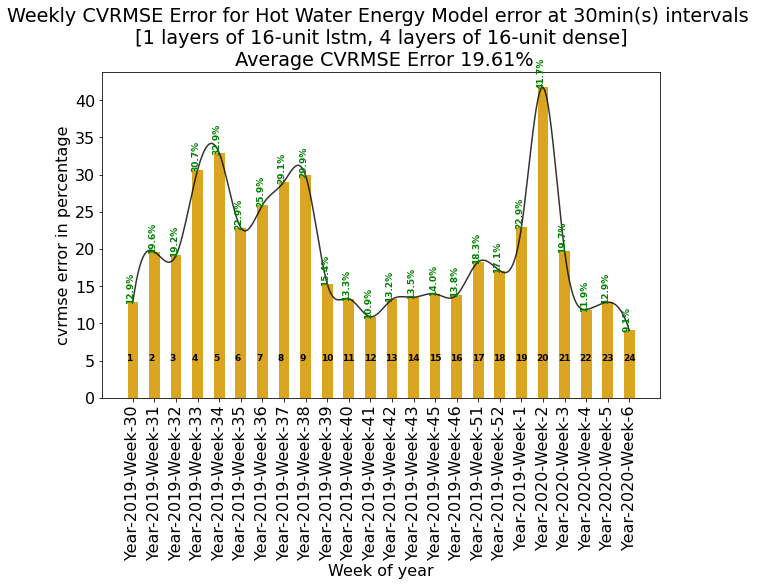

In [22]:
# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 1 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Model error at {5:}min(s) intervals \n [{0:} layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse,5*period),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=6,
    fontsize=16)
pu.single_bar_plot(**plot_args)

### Merge the pdfs together

In [23]:
# path where files are stored
pdfs_loc = path + 'detailedplots/'
# list all the files
flist = sorted(
    glob.glob(os.path.join(pdfs_loc, '*'))
)

In [24]:
from PyPDF2 import PdfFileMerger, PdfFileReader
 
# Call the PdfFileMerger
mergedObject = PdfFileMerger()
 
# I had 116 files in the folder that had to be merged into a single document
# Loop through all of them and append their pages
for filename in flist:
    mergedObject.append(PdfFileReader(filename, 'rb'))
    
#  Write all the files into a file which is named as shown below
mergedObject.write(path+'DetailedPredvsTarget.pdf')

### Code cemetery

In [ ]:
# from keras.utils import plot_model
# plot_model(nn_model.model, to_file='model.png',show_shapes=True,)


# # Check the trainable status of the individual layers
# for layer in nn_model.model.layers:
#     print(layer, layer.trainable, layer.name)


#model.model.summary()


#nn_model.model.layers[-1].input_shape
#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())
#nn_model.model.layers[-1].output_shape